# Toxicity Classification

1. #### Problem Defination 

        When person sees negative comments about themselves. They feel suffocated, deppressesd, anxiety hit them. so, to solve this problem and encourage people to give positive comments, me and my team is creating the toxicity classifier which can classifies negative, positive words and comments. 

2. #### Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd 
import os 
from bs4 import BeautifulSoup
import re, string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pylab as plt
import nltk 
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import html
import unicodedata
print(os.getcwd())

c:\Users\Asus\Documents\zenscroll_app


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


3. #### finding and reading the datas

In [2]:
train = pd.read_csv("dataset/train/train.csv", encoding="utf-8")
test = pd.read_csv("dataset/test/test.csv",  encoding="utf-8")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

4. #### Data Preprocessing (Text Cleaning)

In [4]:
def clean_text(text):

    # removing stop words from text s
    stop = set(stopwords.words('english'))
    # updating the text with punctuation to make new line. 
    stop.update(list(string.punctuation))

    # Remove unwanted html characters
    remove_html_chars = re.compile(r'  +')
    replace_char = text.lower().replace('#39;', "'")\
                .replace('amp;', '&').replace('#146;', "'")\
                .replace('nbsp;', ' ').replace('#36;', '$')\
                .replace('\\n', "\n").replace('quot;', "'")\
                .replace('<br />', "\n").replace('\\"', '"')\
                .replace('<unk>', 'u_n').replace(' @.@ ', '.')\
                .replace(' @-@ ', '-').replace('\\', ' \\ ')
    text = remove_html_chars.sub(' ', html.unescape(replace_char))
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # remove between square characters 
    text = re.sub('\[[^]]*\]', '', text)

    # remove URLs 
    text = re.sub(r'https://\S+', '', text)

    # remove tags 
    text = text.replace("@", "")

    # remove hashtags
    text = text.replace("#", '')

    # remove all non alphaetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # replace underscores
    text = text.replace("_", " ")

    # replace - 
    text = text.replace('-', ' ')

    tokens = nltk.word_tokenize(text)

    # remove stopwords 
    stopped_words = [word for word in tokens if word not in stop]

    # converting the words to base by removing the suffixes
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stopped_words]
    clean_text = " ".join(lemmatized_words)

    return clean_text 

In [5]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
train.isna().sum()

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [7]:
train.shape

(1804874, 45)

In [8]:
zen_data = train.copy()
zen_data['threat'] = np.where(zen_data['threat'] >= .25, 1, 0)
zen_data['severe_toxicity'] = np.where(zen_data['severe_toxicity'] >= .25, 1, 0)
zen_data['insult'] = np.where(zen_data['insult'] >= .25, 1, 0)
zen_data['obscene'] = np.where(zen_data['obscene'] >= .25, 1, 0)
zen_data['identity_attack'] = np.where(zen_data['identity_attack'] >= .25, 1, 0)

In [9]:
possible_labels = ["comment_text","target","severe_toxicity", "obscene", "threat", "insult", "identity_attack"]
dataset = zen_data[possible_labels]
dataset = dataset[(dataset['target']>=.5)]
dataset.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0
5,ur a sh*tty comment.,0.666667,0,1,0,1,0
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0


In [10]:
dataset.isna().sum()
dataset.duplicated().sum()
dataset.drop_duplicates(keep='first')

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0
5,ur a sh*tty comment.,0.666667,0,1,0,1,0
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0
...,...,...,...,...,...,...,...
1804825,Who is the jerk in the last row between the C ...,0.833333,0,0,0,1,0
1804838,Nobody really cares that she supports the scie...,0.700000,0,0,0,1,0
1804856,Believing in God or not believing in God are p...,0.500000,0,0,0,1,1
1804857,"I take your point, but I think you're shooting...",0.700000,0,1,0,1,0


In [11]:
dataset['clean_text'] = dataset['comment_text'].apply(clean_text)
dataset.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack,clean_text
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,haha guy bunch loser
5,ur a sh*tty comment.,0.666667,0,1,0,1,0,ur shtty comment
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0,ridiculous guy called protester armed threat v...
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0,story get ridiculous hour love people sending ...
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0,angry troll misogynist racist oh doesnt take i...


5. #### Exploratory Data Analysis (EDA)

In [36]:
clean_text = dataset.iloc[:5000, 7].values

cloud_words = []
for sent in clean_text:
    cloud_words.append(sent)

cloud_words = ' '.join(cloud_words)
print(cloud_words)

haha guy bunch loser ur shtty comment ridiculous guy called protester armed threat violence make terrorist story get ridiculous hour love people sending guy dildo mail really think there happy ending think theyre even deluded joke assume angry troll misogynist racist oh doesnt take iq see slant diversity diode work yet say anything want diversity hand must say allow say winning argument member diversity considered offensive language fact cogent linear post math verboten yet call muslim act get pilloried okay smear entire religion idiot okay bash christian sect bitch nut would read book woman tuesday jan member socalled militia traveled john dayor try enlist sherif come malheur support refused go without approval local sheriff burn dave ward sheriff ward said wanted john day sheriff come burn would willing shame humiliate trespasser leaving bundy bunch armed terrorist idiot attempting poison state toxic divisive brand politics need arrested prosecuted rally support public land malheur r

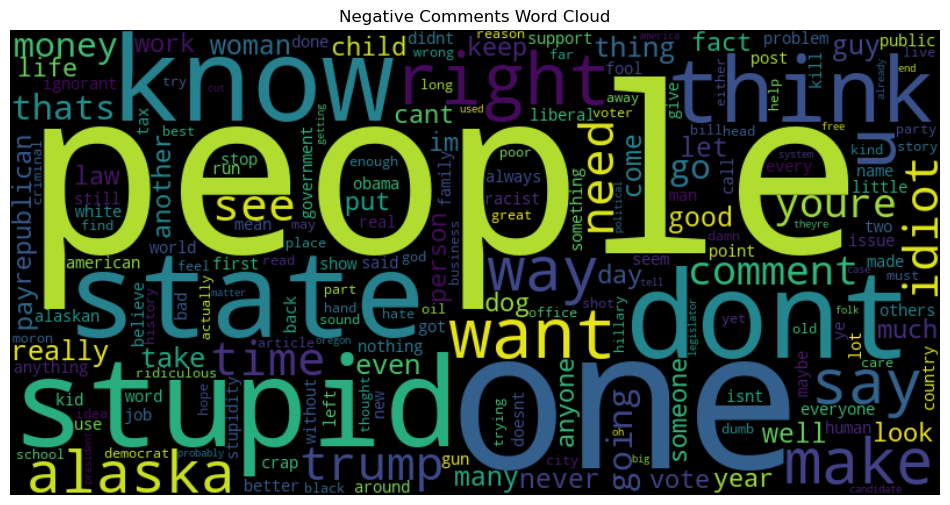

In [39]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(cloud_words)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Comments Word Cloud')
plt.show()

In [ ]:
def count_characters(text):
    icount = 0
    for word in text:
        if word.isdigit():
            continue
        icount = icount + 1
    return icount

15

In [41]:
dataset['num_characters'] = dataset['clean_text'].apply(count_characters)
dataset['num_words'] = dataset['clean_text'].apply(lambda x : len(nltk.word_tokenize(x)))
dataset['num_sentences'] = dataset['clean_text'].apply(lambda x : len(nltk.sent_tokenize(x)))

In [42]:
dataset[['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,144334.000000,144334.000000,144334.000000
mean,173.531774,0.999979,25.275327
std,154.863004,0.004559,21.977364
min,0.000000,0.000000,0.000000
25%,61.000000,1.000000,9.000000
50%,122.000000,1.000000,18.000000
75%,232.000000,1.000000,34.000000
max,953.000000,1.000000,305.000000


In [44]:
# word with obscene offensive, rude, or shocking, usually because of being too obviously related to sex or showing sex
dataset[dataset['obscene'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,18952.000000,18952.0,18952.000000
mean,182.149430,1.0,27.323185
std,162.076762,0.0,23.484097
min,2.000000,1.0,1.000000
25%,60.000000,1.0,10.000000
50%,128.000000,1.0,19.000000
75%,253.000000,1.0,38.000000
max,780.000000,1.0,109.000000


In [46]:
# severe toxicity 
dataset[dataset['severe_toxicity'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,559.000000,559.0,559.000000
mean,182.747764,1.0,27.032200
std,172.926443,0.0,24.709401
min,4.000000,1.0,1.000000
25%,49.000000,1.0,8.000000
50%,112.000000,1.0,18.000000
75%,266.500000,1.0,39.000000
max,751.000000,1.0,103.000000


In [47]:
dataset[dataset['threat'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,8864.000000,8864.0,8864.000000
mean,126.419562,1.0,19.220329
std,128.900495,0.0,18.733409
min,3.000000,1.0,1.000000
25%,43.000000,1.0,7.000000
50%,82.000000,1.0,13.000000
75%,159.000000,1.0,24.000000
max,792.000000,1.0,118.000000


In [48]:
dataset[dataset['insult'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,130549.000000,130549.000000,130549.000000
mean,176.717118,0.999977,25.713180
std,155.807511,0.004794,22.110524
min,0.000000,0.000000,0.000000
25%,63.000000,1.000000,10.000000
50%,125.000000,1.000000,18.000000
75%,237.000000,1.000000,34.000000
max,953.000000,1.000000,305.000000


In [49]:
dataset[dataset['identity_attack'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,25151.000000,25151.0,25151.000000
mean,202.716512,1.0,29.079202
std,167.181575,0.0,23.549527
min,3.000000,1.0,1.000000
25%,77.000000,1.0,11.000000
50%,147.000000,1.0,21.000000
75%,279.000000,1.0,40.000000
max,953.000000,1.0,305.000000
